# __Importing Libraries__

In [22]:
'''Basic Libraries'''
import pandas as pd 
import numpy as np 
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt 
import os.path 
import regex as re
import warnings 
import cv2
import math
import zipfile
import itertools
warnings.filterwarnings('ignore')


'''Preprocessing and Modeliing Libraries'''
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, AveragePooling2D, Input, Flatten, add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.utils import to_categorical, plot_model
import tensorflow as tf 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from lime import lime_image
from skimage.segmentation import mark_boundaries

# with zipfile.ZipFile('/content/drive/MyDrive/archive.zip', 'r') as zip_ref:
#     zip_ref.extractall('/content/')

__

# __Data Preprocessing and Transformation__

In [5]:
infected_path = '/content/cell_images/cell_images/Parasitized/'
uninfected_path = '/content/cell_images/cell_images/Uninfected/'

In [6]:
Pimages = os.listdir(infected_path)
Nimages = os.listdir(uninfected_path)

In [7]:
data=[]
labels=[]
Parasitized=os.listdir("cell_images/Parasitized/")
for a in Parasitized:
    try:
        image=cv2.imread("cell_images/Parasitized/"+a)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((50, 50))
        data.append(np.array(size_image))
        labels.append(0)
    except AttributeError:
        print("")

Uninfected=os.listdir("cell_images/Uninfected/")
for b in Uninfected:
    try:
        image=cv2.imread("cell_images/Uninfected/"+b)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((50, 50))
        data.append(np.array(size_image))
        labels.append(1)
    except AttributeError:
        print("")

In [8]:
data=np.array(data)
labels=np.array(labels)

In [9]:
s=np.arange(data.shape[0])
np.random.shuffle(s)
data=data[s]
labels=labels[s]

In [10]:
num_classes=len(np.unique(labels))
len_data=len(data)

(x_train,x_test)=data[(int)(0.1*len_data):],data[:(int)(0.1*len_data)]
x_train = x_train.astype('float32')/255 # As we are working on image data we are normalizing data by divinding 255.
x_test = x_test.astype('float32')/255
train_len=len(x_train)
test_len=len(x_test)

In [11]:
(y_train,y_test)=labels[(int)(0.1*len_data):],labels[:(int)(0.1*len_data)]

In [12]:
#Doing One hot encoding as classifier has multiple classes
y_train = to_categorical(y_train,num_classes)
y_test = to_categorical(y_test,num_classes)

In [ ]:
y_train.shape

(24803, 2)

# __Model Building__



In [ ]:
#creating sequential model
model=Sequential()
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu",input_shape=(50,50,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))


model.add(Flatten())

model.add(Dense(512,activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(2,activation="softmax"))#2 represent output layer neurons 
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 50, 50, 32)        416       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 25, 25, 32)        4128      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 12, 12, 32)       

In [ ]:
#Prepare model save directory
save_dir = os.path.join(os.getcwd(), 'model')
model_name = 'malaria_calssifier_model.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir,model_name)

In [ ]:
#Callbacks 
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,            
                               min_lr=0.5e-6)
callbacks = [checkpoint, lr_reducer]

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])
h=model.fit(x_train,y_train,
            batch_size=32,callbacks=callbacks, 
            validation_data=(x_test,y_test),epochs=20,verbose=1)

Epoch 1/20
776/776 [==============================] - 5s 6ms/step - loss: 0.6246 - accuracy: 0.6080 - val_loss: 0.1774 - val_accuracy: 0.9463

Epoch 00001: val_accuracy improved from -inf to 0.94628, saving model to /content/model/malaria_calssifier_model.h5
Epoch 2/20
776/776 [==============================] - 4s 5ms/step - loss: 0.1907 - accuracy: 0.9369 - val_loss: 0.1546 - val_accuracy: 0.9546

Epoch 00002: val_accuracy improved from 0.94628 to 0.95463, saving model to /content/model/malaria_calssifier_model.h5
Epoch 3/20
776/776 [==============================] - 4s 5ms/step - loss: 0.1718 - accuracy: 0.9450 - val_loss: 0.1589 - val_accuracy: 0.9535

Epoch 00003: val_accuracy did not improve from 0.95463
Epoch 4/20
776/776 [==============================] - 4s 5ms/step - loss: 0.1652 - accuracy: 0.9491 - val_loss: 0.1480 - val_accuracy: 0.9525

Epoch 00004: val_accuracy did not improve from 0.95463
Epoch 5/20
776/776 [==============================] - 4s 5ms/step - loss: 0.1529 - 

# __Model Evaluation__

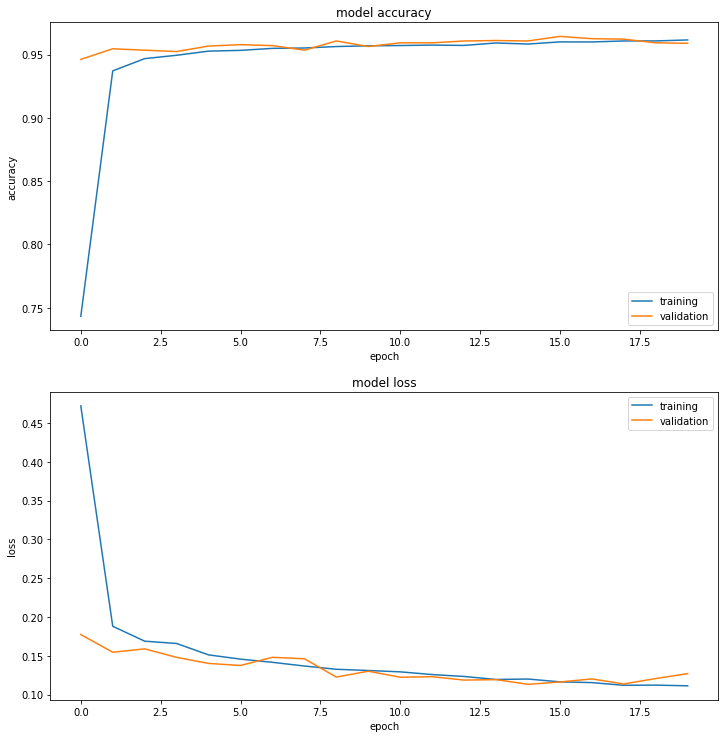

In [ ]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(10,10))
plt.tight_layout()
display_training_curves(h.history['accuracy'], h.history['val_accuracy'], 'accuracy', 211)
display_training_curves(h.history['loss'], h.history['val_loss'], 'loss', 212)

In [13]:
model = load_model('/content/malaria_calssifier_model.h5')

In [14]:
score=model.evaluate(x_test,y_test)
print(score)

87/87 [==============================] - 32s 4ms/step - loss: 0.1013 - accuracy: 0.9601
[0.1012834757566452, 0.9600725769996643]


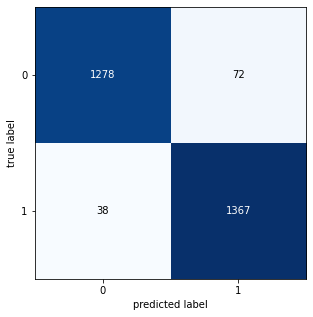

In [15]:
from sklearn.metrics import confusion_matrix
pred = model.predict(x_test)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)

CM = confusion_matrix(y_true, pred)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [ ]:
# get predictions on the test set
y_hat = model.predict(x_test)

# define text labels (source: https://www.cs.toronto.edu/~kriz/cifar.html)
malaria_labels = ['Parasitized','Uninfected']

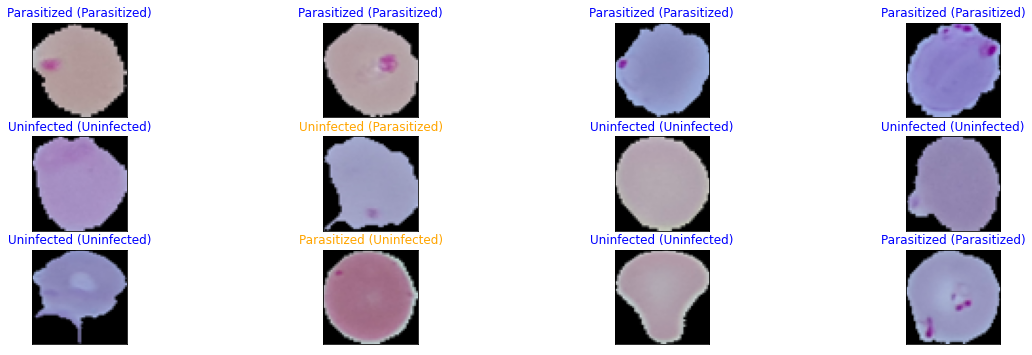

In [ ]:
# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=12, replace=False)):
    ax = fig.add_subplot(4,4, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(malaria_labels[pred_idx], malaria_labels[true_idx]),
                 color=("blue" if pred_idx == true_idx else "orange"))

__Observations:__

__Observaations:__

- The model is not overfitting, which is a good thingg.
- The model is giving a accuracy score of 96% on test dataset. 
- We can observe that our model is able to identified most of the images correctly. 

# __Model Explanaiblity Using LIME__

In [ ]:
#Passing a random image
random_image =  '/content/cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_171.png'

#Function to print the prediction of an image
def model_predict(img_path, model):
    img = load_img(img_path, target_size=(50,50)) #target_size must agree with what the trained model expects!!
    # Preprocessing the image
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)   
    preds = model.predict(img)
    pred = np.argmax(preds,axis = 1)
    str1 = 'Malaria Parasitized'
    str2 = 'Normal'
    if pred[0] == 0:
        return str1
    else:
        return str2

#Function to read and transform images from path   
def read_and_transform(image_path):
    img = load_img(image_path, target_size=(50,50)) #target_size must agree with what the trained model expects!!
    # Preprocessing the image
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return img


#Using lime to explain the model prediction
def explain_prediction(image_path, model):
    image = read_and_transform(image_path)
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(image[0].astype('double'), model.predict,top_labels=2, hide_color=0, num_samples=1000)

    temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
    temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
    ax1.imshow(mark_boundaries(temp_1, mask_1))
    ax2.imshow(mark_boundaries(temp_2, mask_2))
    ax1.axis('off')
    ax2.axis('off')
    plt.show()
    return ax1, ax2

print(model_predict(random_image, model))
explain_prediction(random_image, model)

__Observations:__
- Now we know that our model classify our image as a Uninfected image
. __On the left image__ we can see that only super pixels where the real cell surface is visible are shown. 
- The white area is the cell composition are where most of the cell image is present.

- This means that our model is able to identify the area which belong to the cell and the one covered in black is mostly the background


- __On the right image__, the area of super-pixels colored in green are the ones that increases the probability of our image belong to infeced class while the super pixel colored in red are 
the ones that decrease tha probability 
- The yellow masked in the center of the image represent the presence of malaria cell, that's why even we can see the prediction for this image as __'Malaria Parasitized'__